In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jeanjagnus","key":"b8b8b7fde18d8154178417666595795b"}'}

In [2]:
import os

!mkdir -p ~/.kaggle/
!mv kaggle.json ~/.kaggle

!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!pip install kaggle

In [4]:
!kaggle datasets download -d bhaveshmittal/celebrity-face-recognition-dataset -p /content/datasets/celebrity_faces --unzip

Dataset URL: https://www.kaggle.com/datasets/bhaveshmittal/celebrity-face-recognition-dataset
License(s): CC0-1.0
 94% 32.0M/34.0M [00:01<00:00, 25.8MB/s]
100% 34.0M/34.0M [00:02<00:00, 17.6MB/s]


In [5]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, save_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt



In [6]:
!gdown --id 14eHppxprE1sCWmnjQ7LuijhAZQlb_Quz #gdown is like asking Google Drive: "Hey, can you send me that file?"

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=14eHppxprE1sCWmnjQ7LuijhAZQlb_Quz
From (redirected): https://drive.google.com/uc?id=14eHppxprE1sCWmnjQ7LuijhAZQlb_Quz&confirm=t&uuid=88778982-495c-4b10-acb6-74d705a0082e
To: /content/vgg_face_weights.h5
100% 580M/580M [00:10<00:00, 54.8MB/s]


In [7]:

model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))  #we output to this for face embeding
model.add(Flatten())
model.add(Activation('softmax'))

model.load_weights('vgg_face_weights.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/zero_padding2d.py:72: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
model.load_weights('vgg_face_weights.h5')

In [9]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img


def findCosineSimilarity(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))


vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [10]:
epsilon = 0.40



def verifyFace(img1, img2):
    print(f"Checking paths:\nImage 1: {img1}\nImage 2: {img2}")

    img1_representation = vgg_face_descriptor.predict(preprocess_image(img1))[0,:]
    img2_representation = vgg_face_descriptor.predict(preprocess_image(img2))[0,:]

    cosine_similarity = findCosineSimilarity(img1_representation, img2_representation)

    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(image.load_img(img1))
    plt.xticks([]); plt.yticks([])

    f.add_subplot(1,2, 2)
    plt.imshow(image.load_img(img2))
    plt.xticks([]); plt.yticks([])

    plt.show(block=True)

    print("Cosine similarity: ", cosine_similarity)

    if cosine_similarity < epsilon:
        print("✅ They are the same person!")
    else:
        print("❌ They are not the same person!")


Checking paths:
Image 1: /content/datasets/celebrity_faces/Angelina Jolie/001_fe3347c0.jpg
Image 2: /content/datasets/celebrity_faces/Brad Pitt/001_c04300ef.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


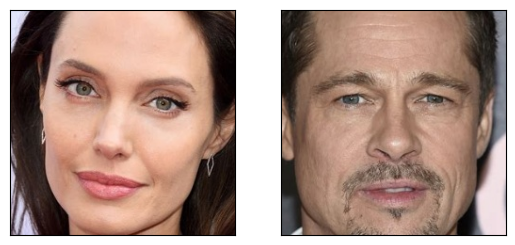

Cosine similarity:  0.7636102735996246
❌ They are not the same person!


In [11]:
verifyFace(
    "/content/datasets/celebrity_faces/Angelina Jolie/001_fe3347c0.jpg",
    "/content/datasets/celebrity_faces/Brad Pitt/001_c04300ef.jpg"
)


Checking paths:
Image 1: /content/datasets/celebrity_faces/Angelina Jolie/001_fe3347c0.jpg
Image 2: /content/datasets/celebrity_faces/Angelina Jolie/003_57612506.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


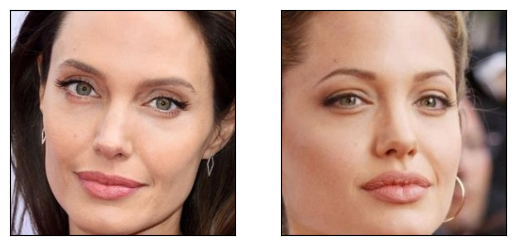

Cosine similarity:  0.34101492166519165
✅ They are the same person!


In [12]:
verifyFace(
    "/content/datasets/celebrity_faces/Angelina Jolie/001_fe3347c0.jpg",
    "/content/datasets/celebrity_faces/Angelina Jolie/003_57612506.jpg"
)
